In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.preprocessing import  StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier


In [2]:
def cm_plot(model,y_test, y_pred, encoder):

    labels=encoder.classes_
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",xticklabels=labels, yticklabels=labels)    
    plt.title(f"Confusion Matrix: {model}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

In [3]:
df=pd.read_csv('./df.csv')

In [4]:
df_sample = df.sample(frac=1, random_state=7)
X=df_sample.drop(columns=['trip_id','plan_duration','passholder_type', 'bike_id', 'time_of_day','year' ])
y=df_sample['passholder_type']
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("LabelEncoder class mapping:", dict(zip(encoder.classes_, range(len(encoder.classes_)))))
encoder2 = LabelEncoder()
X['trip_route_category'] = encoder2.fit_transform(X['trip_route_category'])
print("LabelEncoder class mapping:", dict(zip(encoder2.classes_, range(len(encoder.classes_)))))

X_train, X_test, y_train, y_test = train_test_split(X,y_encoded, test_size=0.20, random_state=7)

LabelEncoder class mapping: {'Annual Pass': 0, 'Flex Pass': 1, 'Monthly Pass': 2, 'One Day Pass': 3, 'Walk-up': 4}
LabelEncoder class mapping: {'One Way': 0, 'Round Trip': 1}


Accuracy: 0.7365799504126115
              precision    recall  f1-score   support

           0       0.73      0.29      0.41      6673
           1       0.59      0.06      0.11      2204
           2       0.75      0.92      0.83     77563
           3       0.55      0.15      0.23      7903
           4       0.71      0.62      0.66     40772

    accuracy                           0.74    135115
   macro avg       0.66      0.41      0.45    135115
weighted avg       0.72      0.74      0.71    135115



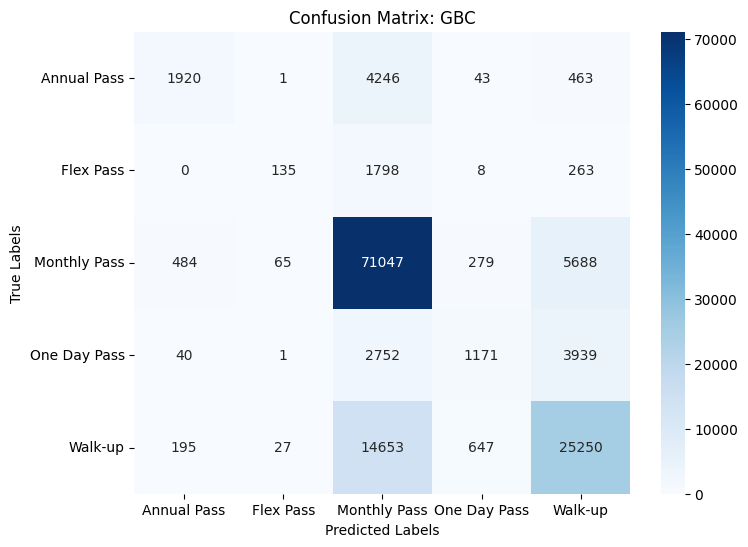

In [6]:
gbc = GradientBoostingClassifier(n_estimators= 218, learning_rate= 0.08552163166263307, max_depth= 9,
                                 min_samples_split= 15, min_samples_leaf= 9, random_state=7)
gbc.fit(X_train, y_train)
y_pred_gbc = gbc.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred_gbc))
print(classification_report(y_test, y_pred_gbc))
cm_plot('GBC', y_test, y_pred_gbc,encoder)

In [7]:
cv_scores = cross_val_score(gbc, X, y_encoded, cv=5, scoring='accuracy')

print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", np.mean(cv_scores))
print("Standard deviation of CV accuracy:", np.std(cv_scores))

Cross-validation scores: [0.73671317 0.74074677 0.73764571 0.73731266 0.738223  ]
Mean CV accuracy: 0.7381282611109056
Standard deviation of CV accuracy: 0.0013975774964732437


In [17]:
df2 = pd.read_csv('./test_set.csv', low_memory=False)
df2['start_time'] = pd.to_datetime(df2['start_time'], format='mixed')
df2['end_time'] = pd.to_datetime(df2['end_time'],format='mixed')
df2["bike_id"] = pd.to_numeric(df2["bike_id"], errors="coerce")
df2 = df2.dropna()
df2['start_time'] = df2['start_time'].astype('int64') // 10**9
df2['end_time'] = df2['end_time'].astype('int64') // 10**9
df2['start_time'] = df2['start_time'].astype('int64') // 10**9
df2['end_time'] = df2['end_time'].astype('int64') // 10**9
X2=df2.drop(columns=['trip_id', 'bike_id'])
encoder2 = LabelEncoder()
X2['trip_route_category'] = encoder2.fit_transform(X2['trip_route_category'])
print("LabelEncoder class mapping:", dict(zip(encoder2.classes_, range(len(encoder.classes_)))))

LabelEncoder class mapping: {'One Way': 0, 'Round Trip': 1}


In [12]:
X2_PRED=gbc.predict(X2)

In [18]:
predicted_labels = encoder.inverse_transform(X2_PRED)

result_df = pd.DataFrame({
    'trip_id': df2['trip_id'].values,
    'passholder_type': predicted_labels
})

print(result_df.head())

    trip_id passholder_type
0  17059130         Walk-up
1  17059129         Walk-up
2  17059126         Walk-up
3  17059125         Walk-up
4  17061379         Walk-up


In [19]:
result_df.to_csv('./resultados.csv')